In [ ]:
!pip install -q boto3
#!pip install -q scikit-learn==0.20.3
#!pip install -q nltk==3.4.5

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

# Copy the datasets from S3 to this notebook instance

In [2]:
# $S3_BUCKET/feature-store/amazon-reviews/balanced-tfidf-without-header/data.csv

prefix_train = 'feature-store/amazon-reviews/balanced-tfidf-without-header/train'
prefix_validation = 'feature-store/amazon-reviews/balanced-tfidf-without-header/validation'
prefix_test = 'feature-store/amazon-reviews/balanced-tfidf-without-header/test'

balanced_tfidf_without_header_train_path = './{}/data.csv'.format(prefix_train)
balanced_tfidf_without_header_validation_path = './{}/data.csv'.format(prefix_validation)
balanced_tfidf_without_header_test_path = './{}/data.csv'.format(prefix_test)

import os
os.makedirs(prefix_train, exist_ok=True)
os.makedirs(prefix_validation, exist_ok=True)
os.makedirs(prefix_test, exist_ok=True)

balanced_tfidf_without_header_train_s3_uri = 's3://{}/{}/data.csv'.format(bucket, prefix_train)
balanced_tfidf_without_header_validation_s3_uri = 's3://{}/{}/data.csv'.format(bucket, prefix_validation)
balanced_tfidf_without_header_test_s3_uri = 's3://{}/{}/data.csv'.format(bucket, prefix_test)

In [3]:
!aws s3 cp $balanced_tfidf_without_header_train_s3_uri $balanced_tfidf_without_header_train_path
!aws s3 cp $balanced_tfidf_without_header_validation_s3_uri $balanced_tfidf_without_header_validation_path
!aws s3 cp $balanced_tfidf_without_header_test_s3_uri $balanced_tfidf_without_header_test_path

download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/balanced-tfidf-without-header/train/data.csv to feature-store/amazon-reviews/balanced-tfidf-without-header/train/data.csv
download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/balanced-tfidf-without-header/validation/data.csv to feature-store/amazon-reviews/balanced-tfidf-without-header/validation/data.csv
download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/balanced-tfidf-without-header/test/data.csv to feature-store/amazon-reviews/balanced-tfidf-without-header/test/data.csv


# Load the data
_Note:  `header=None`_

In [120]:
def load_dataset(path, sep, header):
    data = pd.read_csv(path, sep=sep, header=header)

    labels = data.iloc[:,0]
    features = data.drop(data.columns[0], axis=1)
    
    if header==None:
        # Adjust the column names after dropped the 0th column above
        # New column names are 0 (inclusive) to len(features.columns) (exclusive)
        new_column_names = list(range(0, len(features.columns)))
        features.columns = new_column_names

    return features, labels

In [121]:
# Load transformed features (is_positive_sentiment, f0, f1, ...)
X_train, y_train = load_dataset(path=balanced_tfidf_without_header_train_path, sep=',', header=None)
X_validation, y_validation = load_dataset(path=balanced_tfidf_without_header_validation_path, sep=',', header=None)
X_test, y_test = load_dataset(path=balanced_tfidf_without_header_test_path, sep=',', header=None)


In [94]:
X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.180635,-0.056508,-0.223100,0.119096,-0.127045,-0.060230,0.220665,0.002691,-0.136736,-0.064765,...,-0.114112,-0.062802,0.066483,0.096016,0.041191,0.014045,-0.065004,0.041024,0.012689,0.005139
1,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000
2,0.213930,0.260375,0.081973,0.006272,-0.078772,-0.013147,-0.023387,-0.007294,0.005259,0.004822,...,0.037022,-0.000408,0.023793,-0.001171,0.010755,0.044452,0.028939,0.033584,-0.054454,0.026652
3,0.217635,0.346261,0.127182,0.073634,-0.052092,0.005775,-0.010056,-0.005239,0.015079,-0.004020,...,-0.008149,-0.007600,0.002600,0.000689,-0.000895,0.006989,0.003098,-0.003399,0.002601,0.000151
4,0.113655,-0.055001,-0.018477,-0.106168,-0.037306,-0.016887,-0.040407,-0.007593,0.020489,0.034478,...,-0.000419,0.009267,-0.009792,0.013246,0.005379,-0.007638,-0.004968,-0.003248,0.012722,-0.003868


# Train model with XGBoost
This may take a few minutes.  Please be patient.

## Install xgboost

In [95]:
!pip install -q xgboost==0.90

tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
awscli 1.18.11 has requirement botocore==1.15.11, but you'll have botocore 1.14.17 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Train the model
_This will take a few minutes.  Please be patient._

In [96]:
import xgboost as xgb
from xgboost import XGBClassifier

objective  = 'binary:logistic'
max_depth  = 5
num_round  = 1

model = XGBClassifier(objective=objective,
                      num_round=num_round,
                      max_depth=max_depth)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_round=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

# Save Model

In [97]:
import os

import pickle as pkl

# See https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html
# Need to save with joblib or pickle.  `xgb.save_model()` does not save feature_names
model_dir  = './model/notebook/'

os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'xgboost-model')
pkl.dump(model, open(model_path, 'wb'))
print('Wrote model to {}'.format(model_path))

Wrote model to ./model/notebook/xgboost-model


# TODO:  Explain Model

# Restore Model 
This simulates restoring a model within an application.

In [98]:
import pickle as pkl

def model_fn(model_dir):
    model_path = os.path.join(model_dir, 'xgboost-model')
    model = pkl.load(open(model_path, 'rb'))
    return model

In [99]:
model_dir  = './model/notebook/'
model_restored = model_fn(model_dir)

# Plot the feature importance for this model
TODO:  Display the values of the features!

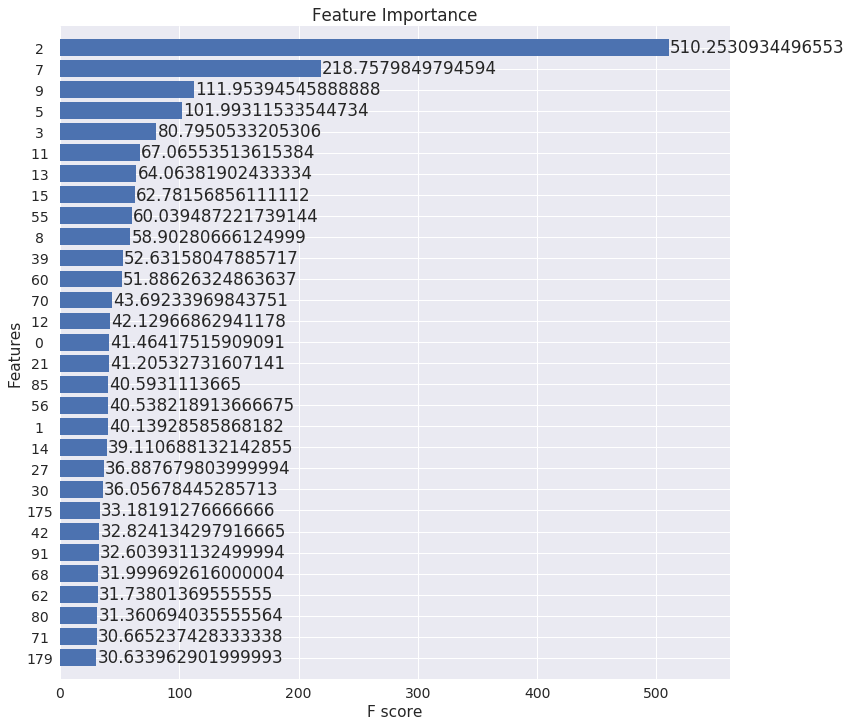

In [100]:
import matplotlib.pyplot as plt
import xgboost

fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model_restored, 
                        importance_type='gain', 
                        max_num_features=30, 
                        height=0.8, 
                        ax=ax, 
                        show_values = True)
plt.title('Feature Importance')
plt.show()

# TODO:  Perform hyperparamter tuning?

# Calculate Validation Metrics

In [101]:
X_validation.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.180635,-0.056508,-0.223100,0.119096,-0.127045,-0.060230,0.220665,0.002691,-0.136736,-0.064765,...,-0.114112,-0.062802,0.066483,0.096016,0.041191,0.014045,-0.065004,0.041024,0.012689,0.005139
1,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000
2,0.213930,0.260375,0.081973,0.006272,-0.078772,-0.013147,-0.023387,-0.007294,0.005259,0.004822,...,0.037022,-0.000408,0.023793,-0.001171,0.010755,0.044452,0.028939,0.033584,-0.054454,0.026652
3,0.217635,0.346261,0.127182,0.073634,-0.052092,0.005775,-0.010056,-0.005239,0.015079,-0.004020,...,-0.008149,-0.007600,0.002600,0.000689,-0.000895,0.006989,0.003098,-0.003399,0.002601,0.000151
4,0.113655,-0.055001,-0.018477,-0.106168,-0.037306,-0.016887,-0.040407,-0.007593,0.020489,0.034478,...,-0.000419,0.009267,-0.009792,0.013246,0.005379,-0.007638,-0.004968,-0.003248,0.012722,-0.003868


In [102]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

auc = model_restored.score(X_validation, y_validation)
print('Validation AUC: ', auc)

preds_validation = model_restored.predict(X_validation)
print('Validation Accuracy: ', accuracy_score(y_validation, preds_validation))
print('Validation Precision: ', precision_score(y_validation, preds_validation, average=None))

Validation AUC:  0.8396455980532851
Validation Accuracy:  0.8396455980532851
Validation Precision:  [0.82574765 0.85492533]


In [103]:
print(classification_report(y_validation, preds_validation))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     16076
           1       0.85      0.82      0.84     15978

   micro avg       0.84      0.84      0.84     32054
   macro avg       0.84      0.84      0.84     32054
weighted avg       0.84      0.84      0.84     32054



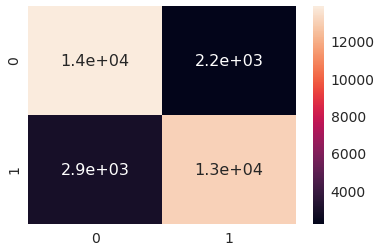

In [104]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_validation = confusion_matrix(y_validation, preds_validation)

#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_validation, annot=True, annot_kws={"size": 16}) # font size

# TODO:  Add labels to each quadrant (False, True / False, True)

plt.show()

# Test Metrics

In [105]:
X_test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.180635,-0.056508,-0.223100,0.119096,-0.127045,-0.060230,0.220665,0.002691,-0.136736,-0.064765,...,-0.114112,-0.062802,0.066483,0.096016,0.041191,0.014045,-0.065004,0.041024,0.012689,0.005139
1,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000
2,0.213930,0.260375,0.081973,0.006272,-0.078772,-0.013147,-0.023387,-0.007294,0.005259,0.004822,...,0.037022,-0.000408,0.023793,-0.001171,0.010755,0.044452,0.028939,0.033584,-0.054454,0.026652
3,0.217635,0.346261,0.127182,0.073634,-0.052092,0.005775,-0.010056,-0.005239,0.015079,-0.004020,...,-0.008149,-0.007600,0.002600,0.000689,-0.000895,0.006989,0.003098,-0.003399,0.002601,0.000151
4,0.113655,-0.055001,-0.018477,-0.106168,-0.037306,-0.016887,-0.040407,-0.007593,0.020489,0.034478,...,-0.000419,0.009267,-0.009792,0.013246,0.005379,-0.007638,-0.004968,-0.003248,0.012722,-0.003868


In [106]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

auc = model_restored.score(X_test, y_test)
print('Test AUC ', auc)

preds_test = model_restored.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test, preds_test))
print('Test Precision: ', precision_score(y_test, preds_test, average=None))

Test AUC  0.8396455980532851
Test Accuracy:  0.8396455980532851
Test Precision:  [0.82574765 0.85492533]


In [107]:
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     16076
           1       0.85      0.82      0.84     15978

   micro avg       0.84      0.84      0.84     32054
   macro avg       0.84      0.84      0.84     32054
weighted avg       0.84      0.84      0.84     32054



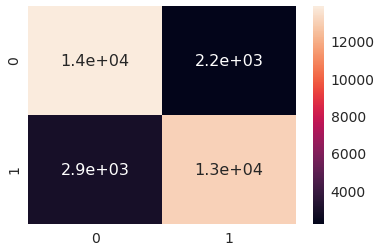

In [108]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_test = confusion_matrix(y_test, preds_test)

#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_test, annot=True, annot_kws={"size": 16}) # font size

# TODO:  Add labels to each quadrant (False, True / False, True)

plt.show()

# Predict in Notebook

Create `feature_transform_fn()` function (same used during `prepare` phase)

In [109]:
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

def feature_transform_fn(df_text):
    text_processors = Pipeline(
        steps=[
            (
                'tfidfvectorizer',
                TfidfVectorizer(
                    max_df=0.25,                                       
                    min_df=.0025,
                    analyzer='word',
                    max_features=10000
                )
            )
        ]
    )

    column_transformer = ColumnTransformer(
        transformers=[('text_processing', text_processors, df_text.columns.get_loc('review_body'))]
    )

    pipeline = Pipeline(
        steps=[
            ('column_transformer',
             column_transformer), ('svd', TruncatedSVD(n_components=300)),
            ('standardscaler', StandardScaler())
        ]
    )

    return pipeline

In [110]:
# $S3_BUCKET/feature-store/amazon-reviews/balanced-raw-with-header/data.csv

prefix_raw = 'feature-store/amazon-reviews/balanced-raw-with-header'

balanced_raw_path = './{}/data.csv'.format(prefix_raw)

import os
os.makedirs(prefix_raw, exist_ok=True)

balanced_raw_s3_uri = 's3://{}/{}/data.csv'.format(bucket, prefix_raw)

In [111]:
!aws s3 cp $balanced_raw_s3_uri $balanced_raw_path

download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/balanced-raw-with-header/data.csv to feature-store/amazon-reviews/balanced-raw-with-header/data.csv


In [122]:
X_raw, y_raw = load_dataset(path=balanced_raw_path, sep=',', header=0)
X_raw.head(5)

,review_body
0,"Strange as it is, it was not as good as the se..."
1,"Funny shows! We laughed out loud, alot!"
2,Well made. Great actors! Christopher Walken ma...
3,"Not my kind of movie, one star was too much"
4,I would have given it a 4 but since I can't ge...


In [ ]:
y_raw.head(5)

In [ ]:
np_tfidf = feature_transform_fn(X_raw).fit_transform(X_raw)
df_tfidf = pd.DataFrame(np_tfidf)
df_tfidf.shape

In [ ]:
df_tfidf.head(5)

In [ ]:
X_raw.head(5)

In [ ]:
y_raw.head(5)

In [ ]:
preds = model_restored.predict(df_tfidf)
df_preds = pd.DataFrame(preds)
df_preds.head(5)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

auc = model_restored.score(df_tfidf, y_raw)
print('Test AUC ', auc)

preds_raw = model_restored.predict(df_tfidf)
print('Test Accuracy: ', accuracy_score(y_raw, preds_raw))
print('Test Precision: ', precision_score(y_raw, preds_raw, average=None))

In [123]:
pd.read_csv(balanced_raw_path)

,is_positive_sentiment,review_body
0,0,"Strange as it is, it was not as good as the se..."
1,0,"Funny shows! We laughed out loud, alot!"
2,0,Well made. Great actors! Christopher Walken ma...
3,0,"Not my kind of movie, one star was too much"
4,0,I would have given it a 4 but since I can't ge...
5,0,I want to like it--but the storylines are a bi...
6,0,At first I thought this was a copy of Atlantis...
7,0,Interesting!
8,0,story line a bit thin
9,0,Favorite &#34;worst movie.&#34;


# TODO:  Deploy the model
1. Create a SageMaker endpoint using this model.

2. Define the predict function to transform raw text into TF/IDF.

In [ ]:
# TODO:  1) update this to do TF/IDF
#        2) use this in other versions of the model
# Derived from the following:
#   https://aim357.readthedocs.io/en/latest/GluePySparkMLFeatureEngineering/GluePySparkMLFeatureEngineering.html#deepar-deep-dive

class XGBoostPredictor(sagemaker.predictor.RealTimePredictor):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_CSV, **kwargs)

    def predict(self, df):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        df -- `pandas.Series` object, the data frame to predict

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        req = self.__encode_request(df)
        # TODO:  change this
        res = predict(req) # super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res)

    def __encode_request(self, df):
        # TODO:  Add transform
#        df = feature_transform
        encoded_request = pd.DataFrame([0,1])
        return encoded_request

    def __decode_response(self, response):
        predictions = response
        return pd.DataFrame(data=predictions)

In [ ]:
xgb_endpoint_name = prefix + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

xgb_predictor = xgb_estimator.deploy(
                     initial_instance_count=1, 
                     instance_type='local',
#                     instance_type='ml.m4.xlarge',
                     predictor_cls=XGBoostPredictor,
                     endpoint_name=xgb_endpoint_name)